In [ ]:
from gensim.models import KeyedVectors, FastText

import pandas as pd
import numpy as np
import importlib

embeddings_to_test=[
    "Embeddings/esIsk.para.lang1.vec",
    "Embeddings/esIskAnchored.para.lang1.vec",
    "Embeddings/isk_anchor_final2.txt",
    "Embeddings/fasttext_bpe.model"
]

import FuncionesPipeline as fp
#Para recargar el módulo durante el desarrollo
importlib.reload(fp)

In [2]:
tokenizadorIsk = fp.descargarTokenizador("Iskonawa")

In [3]:
test_words = ['yuma chuchu', 'hontapa', 'ima']

In [4]:
def load_embeddings(embedding_path):
    if embedding_path.endswith('.vec') or embedding_path.endswith('.txt'):
        # Load embeddings in Word2Vec format
        return KeyedVectors.load_word2vec_format(embedding_path, binary=False)
    elif embedding_path.endswith('.model'):
        # Load FastText model
        return FastText.load(embedding_path)
    else:
        print(f"Unsupported file format: {embedding_path}")
        return None

In [5]:
titles={
    "Embeddings/esIsk.para.lang1.vec":"(Wada et al., 2020)",
    "Embeddings/esIskAnchored.para.lang1.vec":" (Wada et al., 2020) con embeddings preentrenados",
    "Embeddings/isk_anchor_final2.txt":"(Eder et al., 2021)",
    "Embeddings/fasttext_bpe.model":"FastText"
}

def test_embeddings(embedding_path):
    try:
        model_type = 'FastText' if embedding_path.endswith('.model') else 'Word2Vec'
        model = load_embeddings(embedding_path)
        
        # Perform basic operations to test the embeddings
        print(f"Testing embeddings from: {embedding_path}")
        
        # Example words/tokens to test
        
        
        for word in test_words:
            tokenized_test_words = tokenizadorIsk.encode_as_pieces(word)
            if model_type == 'FastText':
                vector = model.wv[word]
                print(f"Vector for '{word}': {vector}")
            else:
                subword_vectors = [model[subword] for subword in tokenized_test_words if subword in model]
                if subword_vectors:
                    averaged_vector = sum(subword_vectors) / len(subword_vectors)
                    print(f"Vector for '{word}': {averaged_vector}")
                else:
                    print(f"'{word}' not found in the embeddings.")
        
        print("\n")
    
    except Exception as e:
        print(f"Error loading {embedding_path}: {e}")

# Test all embeddings
# for embedding_path in embeddings_to_test:
#     test_embeddings(embedding_path)

In [ ]:
df_corpus = pd.read_json('https://raw.githubusercontent.com/Xnehil/Tesis/main/O1_Corpus/corpus.json', lines=True)
tokens= fp.pipeline(df_corpus)

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from gensim.models import FastText, KeyedVectors
from sklearn.decomposition import PCA


def cluster_and_visualize_embeddings(embedding_path, test_input, num_clusters=4):
    model_type = 'FastText' if embedding_path.endswith('.model') else 'Word2Vec'
    model = load_embeddings(embedding_path)
    if not model:
        return

    word_vectors = []
    for item in test_input: #Item could be a word or a sentence
        #item is an array of subwords (tokens)
        if model_type == 'FastText':
                subword_vectors = [model.wv[subword] for subword in item if subword in model.wv]
        else:
            subword_vectors = [model[subword] for subword in item if subword in model]
        
        if subword_vectors:
            word_vector = np.mean(subword_vectors, axis=0)
            word_vectors.append(word_vector)
            

    
    if not word_vectors:
        print(f"No word vectors found for any tokens in {embedding_path}")
        return

    # Convert list to numpy array
    word_vectors = np.array(word_vectors)

    # Perform KMeans clustering
    n_clusters = num_clusters
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(word_vectors)

    # Dimensionality reduction with t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=123, perplexity=5)
    embeddings_2d = tsne.fit_transform(word_vectors)

    # Plotting the clusters
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot each cluster
    for i in range(n_clusters):
        points = embeddings_2d[cluster_labels == i]
        ax.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}')
        
    # Set title and labels
    ax.set_title(f'Embeddings a nivel de palabra para {titles[embedding_path]}', fontdict={'weight': 'bold'})
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.legend()
    
    # Return the figure object
    return fig

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

def evaluate_embeddings(embedding_path, test_input, num_clusters=5):
    # Load the embeddings
    if embedding_path.endswith('.vec') or embedding_path.endswith('.txt'):
        model = KeyedVectors.load_word2vec_format(embedding_path, binary=False)
        model_type = 'KeyedVectors'
    elif embedding_path.endswith('.model'):
        model = FastText.load(embedding_path)
        model_type = 'FastText'
    else:
        print(f"Unsupported file format: {embedding_path}")
        return
    
    word_vectors = []
    for item in test_input: #Item could be a word or a sentence
        #item is an array of subwords (tokens)
        if model_type == 'FastText':
                subword_vectors = [model.wv[subword] for subword in item if subword in model.wv]
        else:
            subword_vectors = [model[subword] for subword in item if subword in model]
        
        if subword_vectors:
            word_vector = np.mean(subword_vectors, axis=0)
            word_vectors.append(word_vector)
    
    word_vectors = np.array(word_vectors)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=4, random_state=123)
    labels = kmeans.fit_predict(word_vectors)
    
    # Compute clustering metrics
    silhouette_avg = silhouette_score(word_vectors, labels)
    davies_bouldin_avg = davies_bouldin_score(word_vectors, labels)
    calinski_harabasz_avg = calinski_harabasz_score(word_vectors, labels)
    
    print(f"Evaluation for {embedding_path}:")
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Davies-Bouldin Index: {davies_bouldin_avg}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz_avg}")
    print("\n")



In [14]:
random_sample = tokens.sample(n=3000)

word_level_embeddings = random_sample['transcription']
#Convert each sentence into an array of words separated by spaces
word_level_embeddings = word_level_embeddings.apply(lambda x: x.split())
#Convert the array of arrays into a single array deleting duplicates
word_level_embeddings = np.unique([word for sublist in word_level_embeddings for word in sublist])
word_level_embeddings = word_level_embeddings.tolist()
word_level_embeddings = tokenizadorIsk.encode_as_pieces(word_level_embeddings)

sentence_level_embeddings =random_sample['tokens']

In [ ]:

figs = []
for i, embedding_path in enumerate(embeddings_to_test):
    print(f"Visualizing for {embedding_path}")
    fig = cluster_and_visualize_embeddings(embedding_path, word_level_embeddings, num_clusters=3)
    figs.append(fig)

In [ ]:
#Join all figures in a single plot
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
for i, ax in enumerate(axs.flat):
    if i < len(figs):
        # Draw the figure on the canvas
        figs[i].canvas.draw()
        
        # Convert the figure to a NumPy array
        img = np.frombuffer(figs[i].canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(figs[i].canvas.get_width_height()[::-1] + (3,))
        
        # Display the image on the subplot
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate all embeddings
for embedding_path in embeddings_to_test:
    evaluate_embeddings(embedding_path, sentence_level_embeddings)

## Deeper into anchored embeddings

In [72]:
embedding_path = 'Embeddings/isk_anchor_final2.txt'
model = KeyedVectors.load_word2vec_format(embedding_path, binary=False)
word_vectors = []
for item in word_level_embeddings: #Item could be a word or a sentence
    subword_vectors = [model[subword] for subword in item if subword in model]       
    if subword_vectors:
        word_vector = np.mean(subword_vectors, axis=0)
        word_vectors.append(word_vector)
        
if not word_vectors:
    print(f"No word vectors found for any tokens in {embedding_path}")


word_vectors = np.array(word_vectors)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(word_vectors)
# # Dimensionality reduction with t-SNE for visualization
# tsne = TSNE(n_components=2, random_state=123, perplexity=5)
# embeddings_2d = tsne.fit_transform(word_vectors)

# # Plotting the clusters
# fig, ax = plt.subplots(figsize=(10, 8))

# # Plot each cluster
# for i in range(n_clusters):
#     points = embeddings_2d[cluster_labels == i]
#     ax.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}')
    
# # Set title and labels
# ax.set_title(f'Embeddings a nivel de palabra para {titles[embedding_path]}', fontdict={'weight': 'bold'})
# ax.set_xlabel('Component 1')
# ax.set_ylabel('Component 2')
# ax.legend()

In [73]:
#Select 30 random rows from df_corpus where id does not contain augmented or eaf 
anchor_sample = tokens[~tokens['id'].str.contains('augmented|eaf')]
anchor_sample = anchor_sample.sample(n=30)

word_level_embeddings = anchor_sample['transcription']
#Convert each sentence into an array of words separated by spaces
word_level_embeddings = word_level_embeddings.apply(lambda x: x.split())
#Convert the array of arrays into a single array deleting duplicates
word_level_embeddings = np.unique([word for sublist in word_level_embeddings for word in sublist])
word_level_embeddings = word_level_embeddings.tolist()
word_level_embeddings = tokenizadorIsk.encode_as_pieces(word_level_embeddings)

sentence_level_embeddings =anchor_sample['tokens']

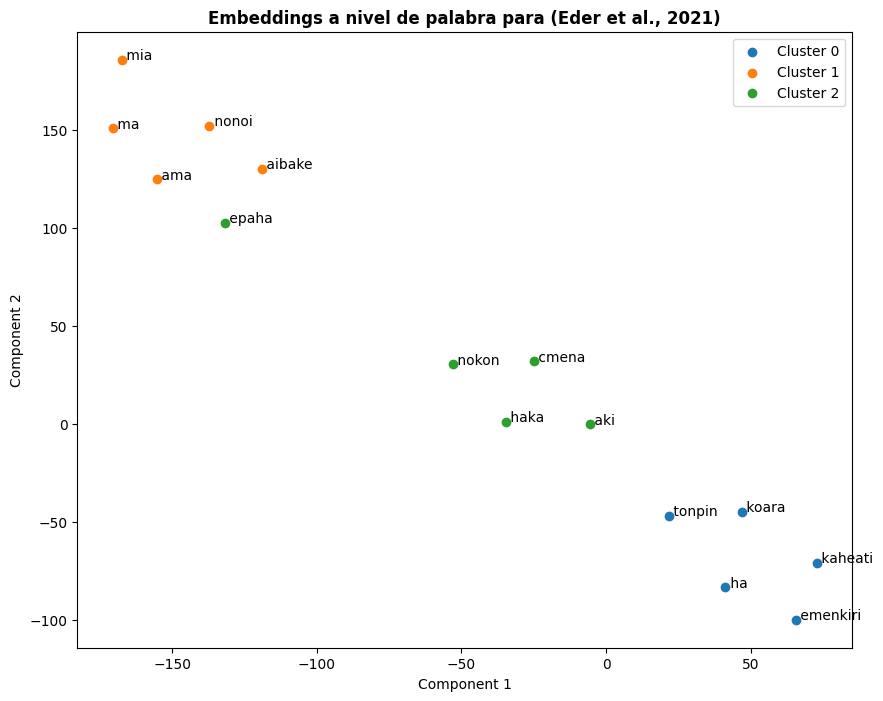

In [88]:
import random
import re

def subwordArrayToWord(array):
    word= "".join(array)
    word.replace("▁"," ")
    word = re.sub(r'▁', ' ', word)
    return word


selected_points = []
selected_words = []
n_words = 5
for cluster in range(n_clusters):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    if len(cluster_indices) >= n_words:
        selected_indices = random.sample(list(cluster_indices), n_words)
    else:
        selected_indices = cluster_indices.tolist()
    selected_points.extend(word_vectors[selected_indices])
    selected_words.extend([word_level_embeddings[i] for i in selected_indices])  # Assuming 'words' is a list of words corresponding to word_vectors


selected_words = [subwordArrayToWord(word) for word in selected_words]
selected_points = np.array(selected_points)

# Dimensionality reduction with t-SNE for visualization
tsne = TSNE(n_components=2, random_state=123, perplexity=5)
embeddings_2d = tsne.fit_transform(selected_points)

# Plotting the clusters
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each cluster
for i in range(n_clusters):
    points = embeddings_2d[i*n_words:(i+1)*n_words]
    ax.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}')
    for j, word in enumerate(selected_words[i*n_words:(i+1)*n_words]):
        ax.annotate(word, (points[j, 0]+0.05, points[j, 1]+0.05))

# Set title and labels
ax.set_title(f'Embeddings a nivel de palabra para {titles[embedding_path]}', fontdict={'weight': 'bold'})
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.legend()




Word level:
Evaluation for Embeddings/esIsk.para.lang1.vec:
Silhouette Score: 0.23679477551225978
Davies-Bouldin Index: 1.8524942034228076
Calinski-Harabasz Index: 315.08789041675226


Evaluation for Embeddings/esIskAnchored.para.lang1.vec:
Silhouette Score: 0.3270224542402323
Davies-Bouldin Index: 0.5008839863791903
Calinski-Harabasz Index: 29.87726604680876


Evaluation for Embeddings/isk_anchor_final2.txt:
Silhouette Score: 0.72349755791228
Davies-Bouldin Index: 0.46584515232684426
Calinski-Harabasz Index: 38757.31321921354


Evaluation for Embeddings/fasttext_bpe.model:
Silhouette Score: -0.015733353793621063
Davies-Bouldin Index: 1.2063040291575384
Calinski-Harabasz Index: 52.18532734929715

Sentence level:
Evaluation for Embeddings/esIsk.para.lang1.vec:
Silhouette Score: 0.004398259712813776
Davies-Bouldin Index: 1.8747624365866127
Calinski-Harabasz Index: 110.63803696032447


Evaluation for Embeddings/esIskAnchored.para.lang1.vec:
Silhouette Score: 0.035177825537814095
Davies-Bouldin Index: 1.4386344792862729
Calinski-Harabasz Index: 597.0240326991185


Evaluation for Embeddings/isk_anchor_final2.txt:
Silhouette Score: 0.6591261789145504
Davies-Bouldin Index: 0.48393160884134834
Calinski-Harabasz Index: 148984.73684591422


Evaluation for Embeddings/fasttext_bpe.model:
Silhouette Score: -0.0005077036912553012
Davies-Bouldin Index: 5.983063624702767
Calinski-Harabasz Index: 332.8110448399215